In [ ]:

 # !pip install scikit-learn
 # !pip install matplotlib
 # !pip install pandas
 # !pip install seaborn


In [ ]:
import os, time, copy, random, hashlib
import numpy as np
import torch, torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.cuda.amp import autocast, GradScaler
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
from PIL import Image

In [ ]:
# Configuration
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)

🖥️ Using device: cuda


In [ ]:
# Dataset & transforms
# Example: reload dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

dataset_path = r"D:\Internship(sujesh)\PlantVillageNew\train"
img_size = 180

train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
def count_duplicates(folder_path):
    hashes = defaultdict(list)
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif")):
                path = os.path.join(root, file)
                with open(path, "rb") as f:
                    h = hashlib.md5(f.read()).hexdigest()
                hashes[h].append(path)

    duplicates = {k: v for k, v in hashes.items() if len(v) > 1}
    total = sum(len(v) for v in duplicates.values())
    print(f"🔁 Duplicate groups: {len(duplicates)}")
    print(f"📸 Total duplicate images (including originals): {total}")
    print(f"⚠️ Redundant images to remove: {total - len(duplicates)}")

# ✅ Example usage
count_duplicates(r"D:\Internship(sujesh)\PlantVillage")

# def remove_duplicate_images(folder_path):
#      hash_map = defaultdict(list)
#      for root, _, files in os.walk(folder_path):
#          for fname in files:
#              if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif")):
#                  path = os.path.join(root, fname)
#                  try:
#                      with open(path, "rb") as f:
#                          h = hashlib.md5(f.read()).hexdigest()
#                      hash_map[h].append(path)
#                  except Exception as e:
#                      print(f"❌ Error reading {path}: {e}")
#      removed = []
#      for group in hash_map.values():
#          for dup in group[1:]:
#              try:
#                  os.remove(dup)
#                  removed.append(dup)
#              except Exception as e:
#                  print(f"⚠️ Could not delete {dup}: {e}")
#      print(f"✅ Removed {len(removed)} duplicate images.")
#      return removed

#  remove_duplicate_images(dataset_path)

🔁 Duplicate groups: 0
📸 Total duplicate images (including originals): 0
⚠️ Redundant images to remove: 0


In [ ]:
# Build MobileNetV2 model
from torchvision.models import mobilenet_v2

full_ds = datasets.ImageFolder(dataset_path, transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)

def build_mobilenet(num_classes, dropout=0.3):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    for param in model.features.parameters():
        param.requires_grad = True  # fine-tune entire model

    in_f = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(in_f, num_classes)
    )
    return model.to(device)



In [ ]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.best_model = None
        self.stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True



In [ ]:
# 🔁 K-Fold CV + Hyperparameter tuning (light)
# 1️⃣ K-Fold CV + Hyperparameter Tuning for MobileNet
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
batch_sizes = [16]
learning_rates = [1e-4]
dropouts = [0.3]

for fold, (train_idx, val_idx) in enumerate(kf.split(full_ds)):
    print(f"\n🔁 Fold {fold+1}/{k_folds}")

    train_subset = torch.utils.data.Subset(full_ds, train_idx)
    val_subset = torch.utils.data.Subset(full_ds, val_idx)
    train_subset.dataset.transform = train_tfms
    val_subset.dataset.transform = val_tfms

    for bs, lr, do in product(batch_sizes, learning_rates, dropouts):
        print(f"\n🔧 Testing: Fold={fold+1} | BS={bs}, LR={lr}, DO={do}")

        batch_size = bs
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                  num_workers=4, pin_memory=True, persistent_workers=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                                num_workers=4, pin_memory=True, persistent_workers=True)

        train_size = len(train_subset)
        val_size = len(val_subset)

        # ✅ Load pretrained MobileNet and modify classifier
        model = torchvision.models.mobilenet_v2(pretrained=True)
        in_f = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=do),
            nn.Linear(in_f, num_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
        early_stop = EarlyStopping(patience=5)

        history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'train_acc': []}
        max_epochs = 10
        scaler = GradScaler()

        for epoch in range(1, max_epochs + 1):
            t0 = time.time()

            # 🔹 Training
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_loss / train_size
            train_acc = correct_train / total_train

            # 🔸 Validation
            model.eval()
            vloss, correct = 0.0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    vloss += loss.item() * images.size(0)
                    preds = outputs.argmax(1)
                    correct += (preds == labels).sum().item()

            val_loss = vloss / val_size
            val_acc = correct / val_size

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch:03}/{max_epochs} | train_loss {train_loss:.4f} | train_acc {train_acc*100:.2f}% | "
                  f"val_loss {val_loss:.4f} | val_acc {val_acc*100:.2f}% | time {time.time()-t0:.1f}s")

            scheduler.step(val_loss)
            for param_group in optimizer.param_groups:
                print(f"🔄 Learning Rate: {param_group['lr']}")

            early_stop(val_loss, model)
            if early_stop.stop:
                print("⏹ Early stopping triggered.")
                break

        model.load_state_dict(early_stop.best_model)
        model_path = f"mobilenet_fold{fold+1}_bs{bs}_lr{lr}_do{do}.pth"
        torch.save(model.state_dict(), model_path)
        print("✅ Best model saved to", model_path)



🔁 Fold 1/5

🔧 Testing: Fold=1 | BS=16, LR=0.0001, DO=0.3


C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\STUDENT\anaconda3\envs\py\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11596\1988961198.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11596\1988961198.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is

Epoch 001/10 | train_loss 0.2937 | train_acc 92.75% | val_loss 0.0354 | val_acc 98.94% | time 126.0s
🔄 Learning Rate: 0.0001
Epoch 002/10 | train_loss 0.0635 | train_acc 98.10% | val_loss 0.0235 | val_acc 99.32% | time 75.6s
🔄 Learning Rate: 0.0001
Epoch 003/10 | train_loss 0.0408 | train_acc 98.76% | val_loss 0.0282 | val_acc 99.08% | time 67.5s
🔄 Learning Rate: 0.0001
Epoch 004/10 | train_loss 0.0353 | train_acc 98.91% | val_loss 0.0183 | val_acc 99.45% | time 71.7s
🔄 Learning Rate: 0.0001
Epoch 005/10 | train_loss 0.0299 | train_acc 99.15% | val_loss 0.0277 | val_acc 99.14% | time 77.4s
🔄 Learning Rate: 0.0001
Epoch 006/10 | train_loss 0.0211 | train_acc 99.32% | val_loss 0.0162 | val_acc 99.47% | time 87.5s
🔄 Learning Rate: 0.0001
Epoch 007/10 | train_loss 0.0240 | train_acc 99.24% | val_loss 0.0265 | val_acc 99.18% | time 70.9s
🔄 Learning Rate: 0.0001
Epoch 008/10 | train_loss 0.0201 | train_acc 99.36% | val_loss 0.0482 | val_acc 98.87% | time 79.9s
🔄 Learning Rate: 0.0001
Epoch 0

In [ ]:
# Restore best model
model.load_state_dict(early_stop.best_model)

# Save model
model_path = f"mobilenet_fold{fold+1}_bs{bs}_lr{lr}_do{do}.pth"
torch.save(model.state_dict(), model_path)
print("✅ Best model saved to", model_path)

# Save history
import pickle
history_path = f"history_vgg16_fold{fold+1}_bs{bs}_lr{lr}_do{do}.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history, f)
print("📁 Training history saved to", history_path)

history_path = f"history_mobilenet_fold{fold+1}_bs{bs}_lr{lr}_do{do}.pkl"

✅ Best model saved to mobilenet_fold5_bs16_lr0.0001_do0.3.pth
📁 Training history saved to history_vgg16_fold5_bs16_lr0.0001_do0.3.pkl


In [ ]:
# ✅ After K-Fold training is done

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define test dataset directory
test_dir = r"D:\Internship(sujesh)\PlantVillageNew\val" # Replace with your test folder path

# Create test dataset with validation transforms
test_ds = ImageFolder(root=test_dir, transform=val_tfms)

# Create DataLoader
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4)

print(f"🧪 Test dataset created with {len(test_ds)} samples from separate folder")
print(f"Test classes: {test_ds.classes}")  # Verify classes match your training data


🧪 Test dataset created with 10851 samples from separate folder
Test classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_lea

In [ ]:
# ✅ Run on test set
model.eval()
correct_test, total_test = 0, 0

# Track per-class accuracy (useful for imbalance)
class_correct = [0] * len(test_ds.classes)
class_total = [0] * len(test_ds.classes)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        # Update overall accuracy
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

        # Update per-class accuracy
        for label, pred in zip(labels, preds):
            class_correct[label] += (label == pred).item()
            class_total[label] += 1

test_acc = correct_test / total_test
print(f"🧪 Final Test Accuracy: {test_acc * 100:.2f}%")

# Print per-class accuracy
for i, classname in enumerate(test_ds.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"Class {classname}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")


🧪 Final Test Accuracy: 99.71%
Class Apple___Apple_scab: 100.00% (126/126)
Class Apple___Black_rot: 100.00% (125/125)
Class Apple___Cedar_apple_rust: 100.00% (55/55)
Class Apple___healthy: 100.00% (324/324)
Class Blueberry___healthy: 100.00% (300/300)
Class Cherry_(including_sour)___Powdery_mildew: 100.00% (210/210)
Class Cherry_(including_sour)___healthy: 99.41% (169/170)
Class Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 95.15% (98/103)
Class Corn_(maize)___Common_rust_: 99.58% (238/239)
Class Corn_(maize)___Northern_Leaf_Blight: 96.45% (190/197)
Class Corn_(maize)___healthy: 100.00% (233/233)
Class Grape___Black_rot: 99.58% (235/236)
Class Grape___Esca_(Black_Measles): 100.00% (276/276)
Class Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 100.00% (215/215)
Class Grape___healthy: 100.00% (84/84)
Class Orange___Haunglongbing_(Citrus_greening): 100.00% (1102/1102)
Class Peach___Bacterial_spot: 100.00% (459/459)
Class Peach___healthy: 100.00% (72/72)
Class Pepper,_bell___Bacterial_sp

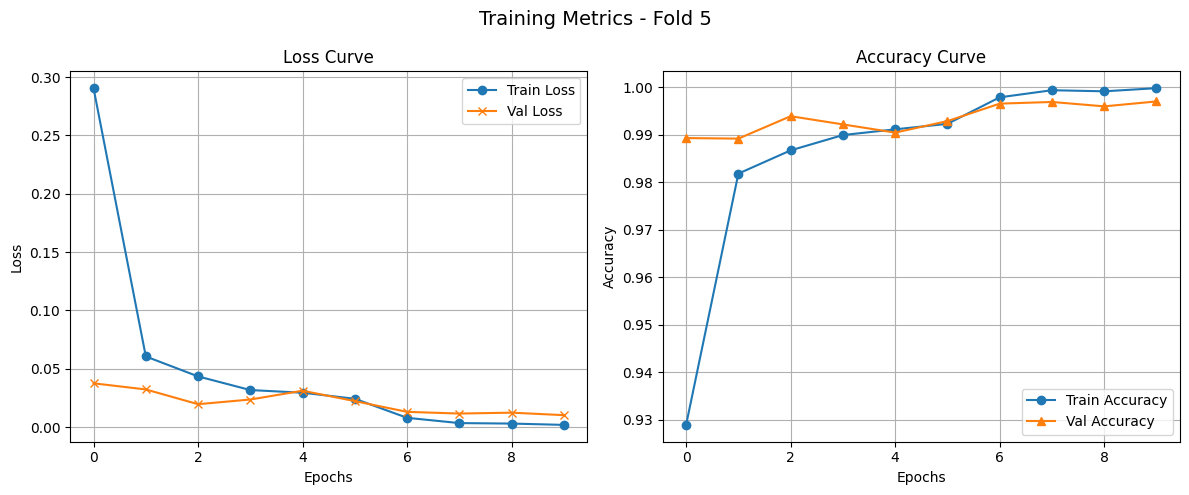

In [ ]:
# Plot both Loss and Accuracy
plt.figure(figsize=(12, 5))

# 🔹 Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

# 🔸 Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Val Accuracy', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

plt.suptitle(f"Training Metrics - Fold {fold+1}", fontsize=14)
plt.tight_layout()
plt.show()

# Save CSV
pd.DataFrame(history).to_csv(f"history_fold{fold+1}_bs{bs}_lr{lr}_do{do}.csv", index=False)


In [ ]:
import pickle

# Replace filename to match your fold and settings
history_path = "history_mobilenet_fold1_bs16_lr0.0001_do0.3.pkl"

with open(history_path, "wb") as f:
    pickle.dump(history, f)

print("✅ History saved as", history_path)


# (in function)
# def load_history(model_name, fold, bs, lr, do):
#     filename = f"history_{model_name}_fold{fold}_bs{bs}_lr{lr}_do{do}.pkl"
#     with open(filename, "rb") as f:
#         return pickle.load(f)

# # Example
# history = load_history("mobilenet", fold=1, bs=16, lr=1e-4, do=0.3)



✅ History saved as history_mobilenet_fold1_bs16_lr0.0001_do0.3.pkl


In [ ]:
with open("history_mobilenet_fold1_bs16_lr0.0001_do0.3.pkl", "rb") as f:
    history = pickle.load(f)


📊 Classification Report
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.99      1.00       103
                                 Apple___Black_rot       0.99      1.00      0.99        99
                          Apple___Cedar_apple_rust       1.00      0.98      0.99        52
                                   Apple___healthy       1.00      1.00      1.00       260
                               Blueberry___healthy       1.00      1.00      1.00       242
          Cherry_(including_sour)___Powdery_mildew       0.99      1.00      1.00       155
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       148
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.93      0.94        98
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       186
               Corn_(maize)___Northern_Leaf_Blight     

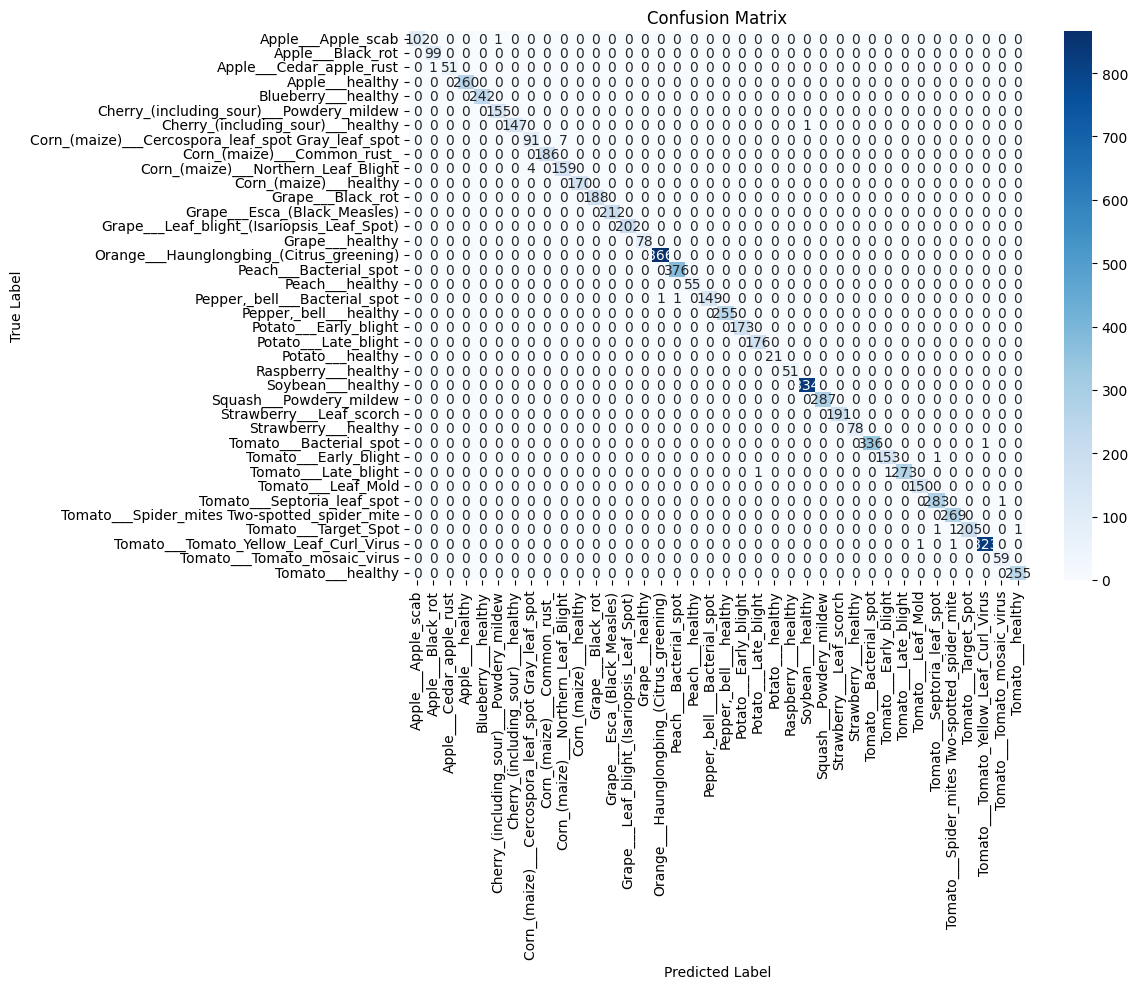

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 🟢 Collect predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Classification Report
print("📊 Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

# 📌 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
torch.save(model.state_dict(), f"mobilenet_final_{timestamp}.pth")


In [ ]:
# Manually log the best results from each fold
best_val_acc = max(history['val_acc'])
best_val_loss = min(history['val_loss'])

results = []  # Definition of ResultArray

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,
    "val_loss": best_val_loss
})

results.append({
    "batch_size": bs,
    "lr": lr,
    "dropout": do,
    "val_acc": best_val_acc,  # capture from training loop
    "val_loss": best_val_loss
})


In [ ]:
import pandas as pd
pd.DataFrame(results).to_csv("hyperparameter_results(MobileNet).csv", index=False)

In [ ]:
#!pip install tensorboard


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# ✅ Log to TensorBoard (after loss and acc are computed)
writer.add_scalar("Loss/train", train_loss, epoch)
writer.add_scalar("Loss/val", val_loss, epoch)
writer.add_scalar("Accuracy/val", val_acc, epoch)

writer.close()


In [ ]:
#!pip install opencv-python


In [ ]:
# print(os.listdir(folder_path))                       # Check what’s really inside


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11596\1268886693.py:156: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_11596\1268886693.py:157: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("gradcam_results.png")  # Save visualization


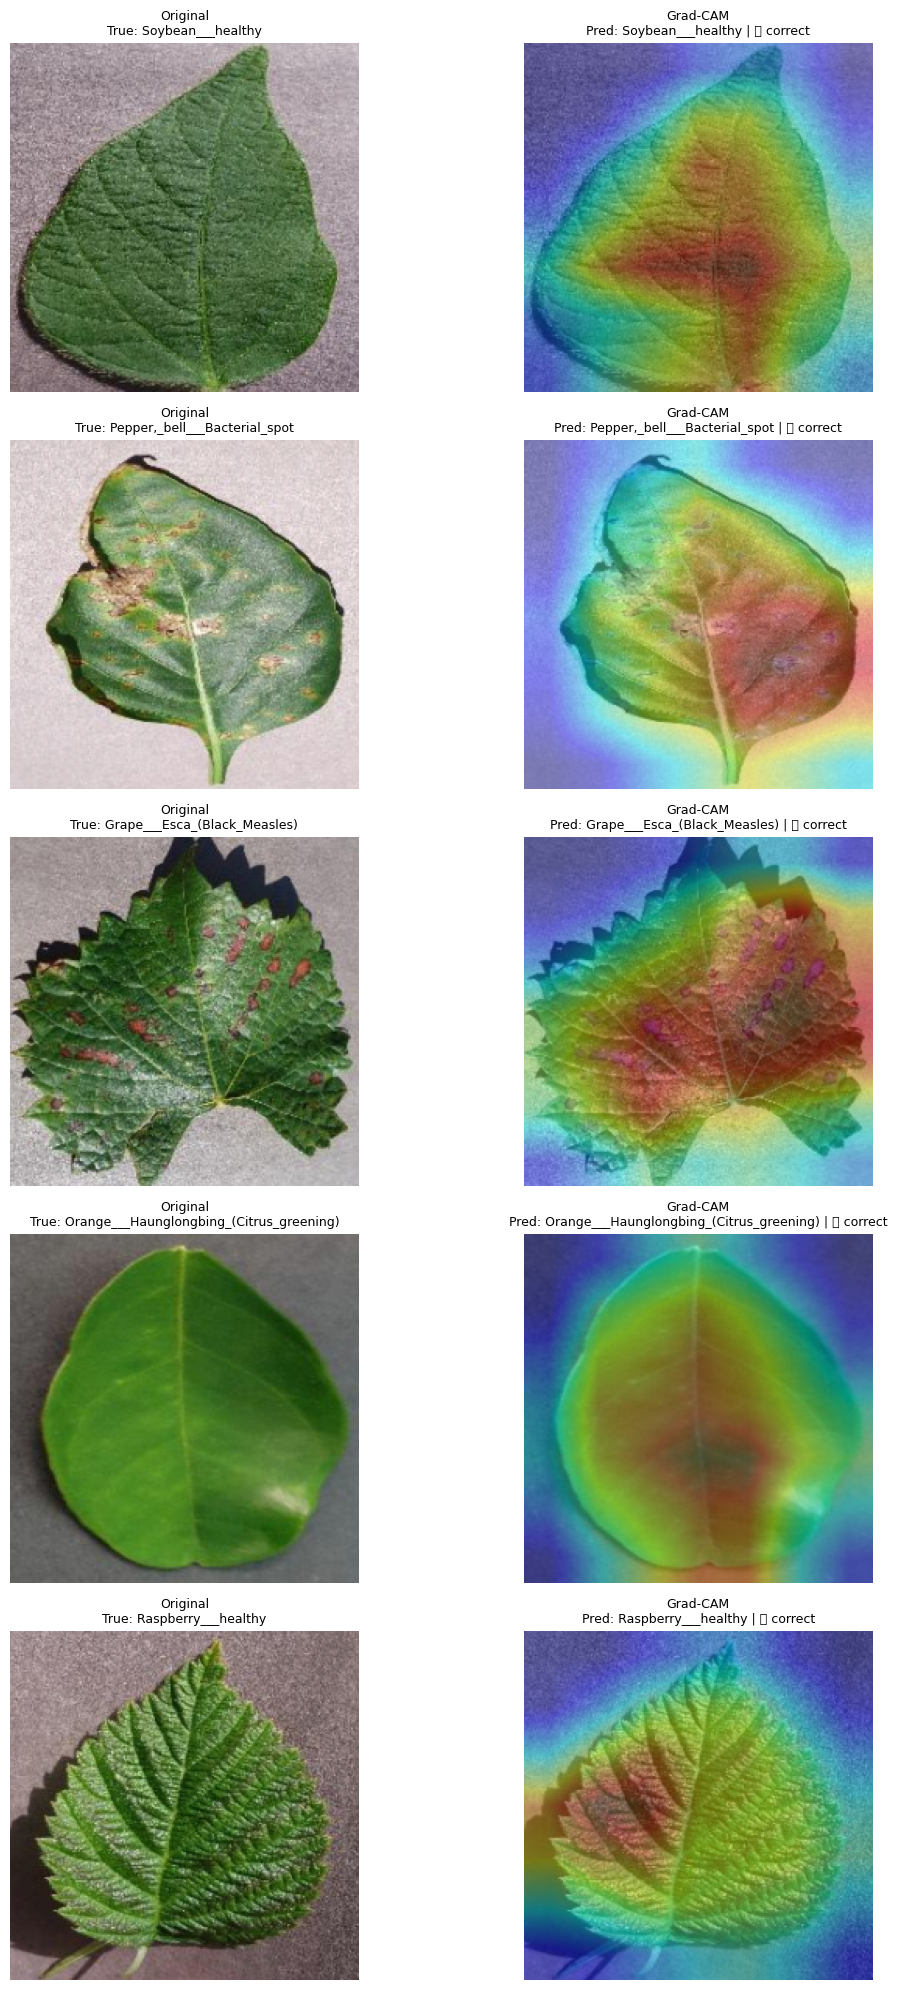

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# ===== CONFIGURATION =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data_path = r"D:\Internship(sujesh)\PlantVillageNew\val" # ← YOUR TEST DATASET PATH HERE
model_path = "mobilenet_final_20250716-1328.pth"  # Your trained model

# ===== CLASS NAMES (from your previous results) =====
class_names = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Blueberry___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Corn_(maize)___healthy',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Raspberry___healthy',
    'Soybean___healthy',
    'Squash___Powdery_mildew',
    'Strawberry___Leaf_scorch',
    'Strawberry___healthy',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]


# ===== LOAD MODEL =====
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)
model.classifier[1] = nn.Linear(model.last_channel, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

# ===== PREPARE TEST DATASET =====
val_transform = weights.transforms()
test_ds = datasets.ImageFolder(test_data_path, transform=val_transform)

# Verify classes match
assert test_ds.classes == class_names, "Class names mismatch between model and dataset!"

# ===== GRAD-CAM CLASS =====
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def save_grads(module, input, output):
            self.activations = output
            output.requires_grad_(True)
            output.register_hook(self.save_gradient)

        self.target_layer.register_forward_hook(save_grads)

    def save_gradient(self, grad):
        self.gradients = grad

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward()

        gradients = self.gradients[0].cpu().detach().numpy()
        activations = self.activations[0].cpu().detach().numpy()
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[2:])
        cam -= cam.min()
        cam /= cam.max()
        return cam

# ===== VISUALIZATION =====
def visualize_gradcam(model, test_ds, num_samples=5):
    target_layer = model.features[-1]  # Last conv layer
    gradcam = GradCAM(model, target_layer)

    indices = random.sample(range(len(test_ds)), num_samples)
    plt.figure(figsize=(12, 4 * num_samples))

    for i, idx in enumerate(indices):
        img, true_label = test_ds[idx]
        img_batch = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_batch)
        pred_class = output.argmax(1).item()

        cam = gradcam.generate(img_batch)

        # De-normalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img.permute(1, 2, 0).cpu().numpy() * std + mean
        img_np = (img_np * 255).astype(np.uint8)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        pred_name = class_names[pred_class]
        true_name = class_names[true_label]
        status = "✅ correct" if pred_class == true_label else "❌ wrong"

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img_np)
        plt.title(f"Original\nTrue: {true_name}", fontsize=9)
        plt.axis("off")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(overlay)
        plt.title(f"Grad-CAM\nPred: {pred_name} | {status}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("gradcam_results.png")  # Save visualization
    plt.show()

# ===== RUN VISUALIZATION =====
visualize_gradcam(model, test_ds, num_samples=5)